In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
today = '200610'

# Time series prediction

In this notebook, we would like to use Reservoir Computing, Structured Reservoir Computing, and Recurrent Kernels for chaotic time series. It will be performed on the Kuramoto-Sivashinsky system with 70,000 for training.

Hyperparameters were found using a grid search (see the previous notebook), and we use the recursive prediction strategy.

## Data generation

In [2]:
seed = 1
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 70000
N_test = 5000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(seed)
dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

# Reservoir Computing

In [3]:
# RC parameters
n_res = 4096-input_dim
input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
alpha = 1e-2
leak_rate = 1

# Generation of train data
pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

print("Training forward")
torch.manual_seed(seed)
bias = bias_scale * torch.randn(n_res).to(device)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                      f='erf', leak_rate=leak_rate, bias=bias, random_projection='gaussian', seed=seed)
X = model.forward(u_train_t).to(device)
X = torch.cat((X, u_train_t*renorm_factor), dim=1)
print("Training weights")
output_w = model.train(X, out_train, alpha=alpha)

Training forward
Training weights


In [4]:
print("Testing forward")
test_len = 4000
Xtest = model.forward(u_test_t[:test_len]).to(device)

print("Testing recursive prediction")
n_rec = 199
rec_pred_data = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)

print("Finished")

Testing forward
Testing recursive prediction
Finished


In [5]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
out_test = out_test[:test_len, :]
truth = out_test[:test_len, :].reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)
    
rec_pred = rec_pred_data.reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
rc_mse = torch.mean(diff**2, dim=2)

In [6]:
# origin = np.argmin(torch.mean(rc_mse[:300, :], dim=1).cpu())
origin = 1000
pred_plot = rec_pred_data[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)
true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

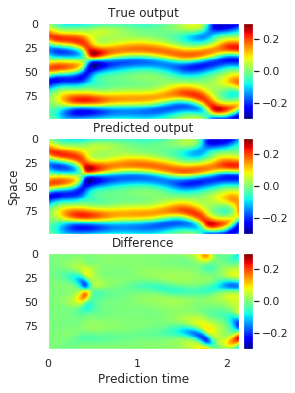

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes  = plt.subplots(3, 1, figsize=(15, 6))
cmap = 'jet'
aspect = 1

plot = axes[0].imshow(true_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[0].grid(b=None)
# axes[0].set_xlabel("Prediction time")
# axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[0].set_xticks([])

plot = axes[1].imshow(pred_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[1].grid(b=None)
# axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[1].set_xticks([])

plot = axes[2].imshow((true_plot-pred_plot).T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
# axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

N_lyap = 2
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = lyap_time / dt
axes[2].set_xticks(np.arange(N_lyap + 1) * int(lyap_idx))
axes[2].set_xticklabels(np.arange(N_lyap + 1));

In [8]:
np.save('out/' + today + '_rc_ks_nres3996_pred', pred_plot.T)
np.save('out/' + today + '_rc_ks_nres3996_true', true_plot.T)

# Structured Reservoir Computing

In [9]:
# RC parameters
n_res = 4096-input_dim
input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
alpha = 1e-2
leak_rate = 1

# Generation of train data
pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

print("Training forward")
torch.manual_seed(seed)
bias = bias_scale * torch.randn(n_res).to(device)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                      f='erf', leak_rate=leak_rate, bias=bias, random_projection='structured', seed=seed)
X = model.forward(u_train_t).to(device)
X = torch.cat((X, u_train_t*renorm_factor), dim=1)
print("Training weights")
output_w = model.train(X, out_train, alpha=alpha)

Training forward
Training weights


In [10]:
print("Testing forward")
test_len = 4000
Xtest = model.forward(u_test_t[:test_len]).to(device)

print("Testing recursive prediction")
n_rec = 600
rec_pred_data = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)

print("Finished")

Testing forward
Testing recursive prediction
Finished


In [11]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon-1, dims=0)
out_test = out_test[:test_len, :]
truth = out_test[:test_len, :].reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)
    
rec_pred = rec_pred_data.reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
src_mse = torch.mean(diff**2, dim=2)

In [12]:
# origin = np.argmin(torch.mean(src_mse[:300, :], dim=1).cpu())
origin = 1000
pred_plot = rec_pred_data[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)
true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

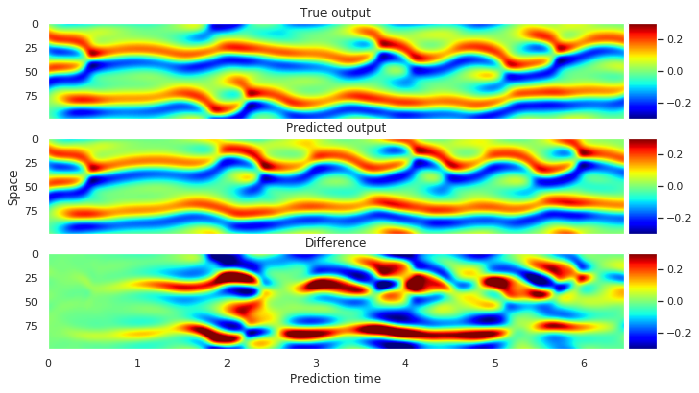

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes  = plt.subplots(3, 1, figsize=(15, 6))
cmap = 'jet'
aspect = 1

# true_plot2 = torch.roll(true_plot, -1, dims=0)

plot = axes[0].imshow(true_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[0].grid(b=None)
# axes[0].set_xlabel("Prediction time")
# axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[0].set_xticks([])

plot = axes[1].imshow(pred_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[1].grid(b=None)
# axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[1].set_xticks([])

plot = axes[2].imshow((true_plot-pred_plot).T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
# axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

N_lyap = 6
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = lyap_time / dt
axes[2].set_xticks(np.arange(N_lyap + 1) * int(lyap_idx))
axes[2].set_xticklabels(np.arange(N_lyap + 1));

In [64]:
np.save('out/' + today + '_src_ks_nres3996_pred', pred_plot.T)
np.save('out/' + today + '_src_ks_nres3996_true', true_plot.T)

# Recurrent Kernels

In [20]:
%%time
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
renorm_factor = 1.1
alpha = 3e-3
n_iter = 50

print("Training forward")
model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=n_iter,
                           bias_scale=bias_scale, memory_efficient=False)

step = 10
in_len = (input_len - n_iter) // step
concat_train = torch.zeros(in_len, n_iter, input_dim).to(device)
for i in range(n_iter):
    concat_train[:, i, :] = u_train_t[i:i+step*in_len:step, :]
K = model.forward(concat_train).to(device)

final_train = concat_train[:, -1, :].reshape(in_len, input_dim)
final_input_gram = final_train @ final_train.T
K += renorm_factor * final_input_gram

print("Training weights")
pred_horizon_range = 1
out_train = torch.zeros(in_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(
        u_train_t, -pred_horizon, dims=0)[n_iter-1:n_iter-1+step*in_len:step, :]

output_w = model.train(K, out_train, alpha=alpha)

print("Testing forward")
test_len = 4000
concat_test = torch.zeros(test_len, n_iter, input_dim).to(device)
for i in range(n_iter):
    concat_test[:, i, :] = u_test_t[i:i+test_len, :]
Ktest, diag_res_train, diag_res_test = model.forward_test(concat_train, concat_test, bypass=True)

print("Testing recursive prediction")
n_rec = 600
rec_pred_data = model.rec_pred_concat(Ktest, concat_train, concat_test, output_w, n_rec,
                                      diag_res_train, diag_res_test, renorm_factor)

print("Finished")

Training forward
Training weights
Testing forward
Testing recursive prediction
Finished
CPU times: user 10min 49s, sys: 4min 55s, total: 15min 44s
Wall time: 10min 42s


In [21]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t[n_iter:n_iter+test_len, :], -pred_horizon, dims=0)
out_test = out_test[:test_len, :]
truth = out_test[:test_len, :].reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

rec_pred = rec_pred_data.reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
rk_mse = torch.mean(diff**2, dim=2)

In [22]:
# origin = np.argmin(torch.mean(rk_mse[:300, :], dim=1).cpu())
origin = 950
pred_plot = rec_pred_data[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)
true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

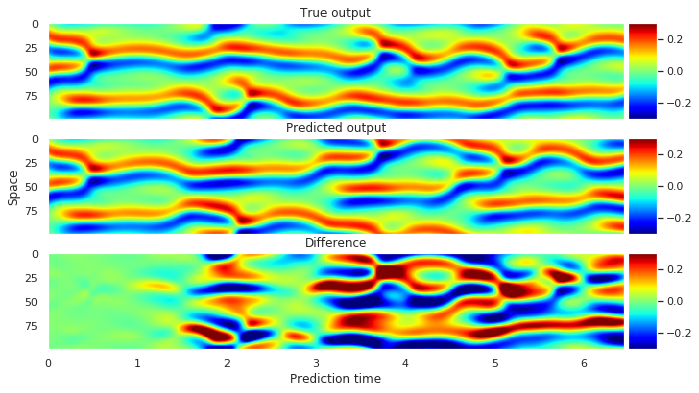

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes  = plt.subplots(3, 1, figsize=(15, 6))
cmap = 'jet'
aspect = 1

plot = axes[0].imshow(true_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[0].grid(b=None)
# axes[0].set_xlabel("Prediction time")
# axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[0].set_xticks([])

plot = axes[1].imshow(pred_plot.T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[1].grid(b=None)
# axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[1].set_xticks([])

plot = axes[2].imshow((true_plot-pred_plot).T, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
# axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

N_lyap = 6
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = lyap_time / dt
axes[2].set_xticks(np.arange(N_lyap + 1) * int(lyap_idx))
axes[2].set_xticklabels(np.arange(N_lyap + 1));

In [57]:
np.save('out/' today + '_rk_ks_true', true_plot.T)
np.save('out/' today + '_rk_ks_pred', pred_plot.T)

# MSE plot

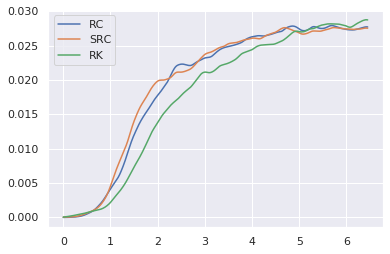

In [25]:
plt.plot(torch.mean(rc_mse, dim=0))
plt.plot(torch.mean(src_mse, dim=0))
plt.plot(torch.mean(rk_mse, dim=0))
plt.legend(['RC', 'SRC', 'RK'])

dt = 0.25
N_lyap = 6
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = lyap_time / dt
plt.xticks(np.arange(N_lyap + 1) * int(lyap_idx), np.arange(N_lyap + 1));

# Rec vs no-rec plot

In [11]:
rec_true = np.load('out/200610_rc_ks_nres3996_true.npy')
rec_pred = np.load('out/200610_rc_ks_nres3996_pred.npy')
norec_true = np.load('out/200609_rc_ks_nres3996_norec_true.npy')
norec_pred = np.load('out/200609_rc_ks_nres3996_norec_pred.npy')

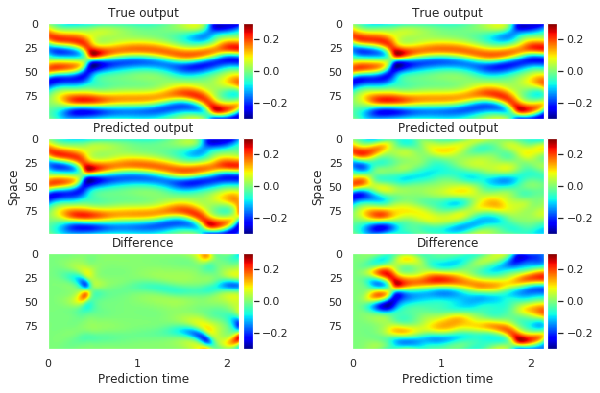

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes  = plt.subplots(3, 2, figsize=(10, 6))
cmap = 'jet'
aspect = 1

plot = axes[0,0].imshow(rec_true, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[0,0].grid(b=None)
axes[0,0].set_title("True output")
divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[0,0].set_xticks([])

plot = axes[1,0].imshow(rec_pred, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[1,0].grid(b=None)
axes[1,0].set_ylabel("Space")
axes[1,0].set_title("Predicted output")
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[1,0].set_xticks([])

plot = axes[2,0].imshow((rec_true-rec_pred), cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[2,0].grid(b=None)
axes[2,0].set_xlabel("Prediction time")
axes[2,0].set_title("Difference");
divider = make_axes_locatable(axes[2,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[0,1].imshow(norec_true, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[0,1].grid(b=None)
axes[0,1].set_title("True output")
divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[0,1].set_xticks([])

plot = axes[1,1].imshow(norec_pred, cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[1,1].grid(b=None)
axes[1,1].set_ylabel("Space")
axes[1,1].set_title("Predicted output")
divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
axes[1,1].set_xticks([])

plot = axes[2,1].imshow((norec_true-norec_pred), cmap=cmap, aspect=aspect, vmin=-0.3, vmax=0.3)
axes[2,1].grid(b=None)
axes[2,1].set_xlabel("Prediction time")
axes[2,1].set_title("Difference");
divider = make_axes_locatable(axes[2,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

N_lyap = 2
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = lyap_time / dt
axes[2,0].set_xticks(np.arange(N_lyap + 1) * int(lyap_idx))
axes[2,0].set_xticklabels(np.arange(N_lyap + 1))
axes[2,1].set_xticks(np.arange(N_lyap + 1) * int(lyap_idx))
axes[2,1].set_xticklabels(np.arange(N_lyap + 1));